### 问题1：开发一个模型，捕捉得分发生时的比赛流程，并将其应用于一场或多场比赛。你的模型 应该识别出哪位球员在比赛的特定时间表现得更好，以及他们的表现有多好。基于你 的模型提供一个可视化来描述比赛流程。注意:在网球比赛中，发球的选手赢得分/局的 概率要高得多。你可能希望以某种方式把这个因素考虑到你的模型中。

具体而言的，由于捕捉网球选手在每一个game里的实时得分相对于捕捉每一场game的输赢是更加困难的，每一个得分的

我们认为，除了是否为发球方，与选手获得胜利的关键相关的原因还和选手的疲惫程度、个人技术能力和比赛实时心态有关。
* 针对个人技术能力，我们可以使用过去或者实时的选手得分情况进行计算
* 针对选手疲惫程度，我们可以使用选手的实时跑图总里程进行计算
* 针对比赛实时心态，我们可以使用是否出现发球失误、是否没有进行加时赛就取得胜利、是否在对方发球时获得得分等指标进行表示
基于此，我们构建了一套实时选手得分表现的评价体系，由下图所示：
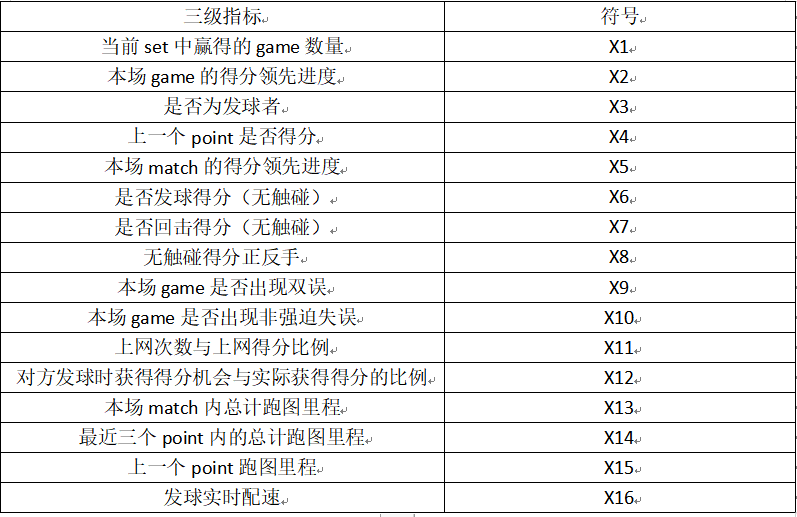

剔除了得分异常的样本,删除了配速有缺失的样本

In [2]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('Wimbledon_featured_matches.csv')
df.loc[(df.p1_score=='AD'),'p1_score'] = 50
df.loc[(df.p2_score=='AD'),'p2_score'] = 50
df['p1_score'] = df['p1_score'].astype(int)
df['p2_score'] = df['p2_score'].astype(int)

df.dropna(subset=['speed_mph'],inplace=True)

In [3]:
x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,\
x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    x1 = point_['p1_games'].values[0]
    x2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    x3 = 1 if point_['serve_no'].values[0] == 1 else 0
    x4 = 0 if x2<0 else 1
    x5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    x6 = 1 if 1 in game_['p1_ace'].values else 0
    x7 = 1 if 1 in game_['p1_winner'].values else 0
    x8 = 1 if 1 in game_['p1_double_fault'].values else 0
    x9 = 1 if 1 in game_['p1_unf_err'].values else 0
    x10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0
    x11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0

    index = match.index.tolist().index(point_.index.tolist()[0])
    x12 = match.iloc[:index+1]['p1_distance_run'].sum()
    x13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    x14 = point_['p1_distance_run'].values[0]
    x15 = point_['speed_mph'].values[0]
    x16 = x15*x3
    
    label = 1 if point_['point_victor'].values[0] == 1 else 0
    label_ls.append(label)
    x1_ls.append(x1)
    x2_ls.append(x2)
    x3_ls.append(x3)
    x4_ls.append(x4)
    x5_ls.append(x5)
    x6_ls.append(x6)
    x7_ls.append(x7)
    x8_ls.append(x8)
    x9_ls.append(x9)
    x10_ls.append(x10)
    x11_ls.append(x11)
    x12_ls.append(x12)
    x13_ls.append(x13)
    x14_ls.append(x14)
    x15_ls.append(x15)
    x16_ls.append(x16)
    

### 处理好的数据如下：

In [4]:
dataset = pd.DataFrame({'x1':x1_ls,'x2':x2_ls,'x3':x3_ls,'x4':x4_ls,'x5':x5_ls,'x6':x6_ls,'x7':x7_ls,'x8':x8_ls,'x9':x9_ls,'x10':x10_ls,'x11':x11_ls,'x12':x12_ls,'x13':x13_ls,'x14':x14_ls,'x15':x15_ls,'x16':x16_ls,'label':label_ls})
dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,label
0,0,0,0,1,0,1,1,0,1,1.0,0.0,6.000,0.000,6.000,95.0,0.0,0
1,0,-15,1,0,0,1,1,0,1,1.0,0.0,11.253,0.000,5.253,118.0,118.0,1
2,0,0,1,1,0,1,1,0,1,1.0,0.0,25.053,25.053,13.800,120.0,120.0,0
3,0,-15,1,0,0,1,1,0,1,1.0,0.0,76.161,70.161,51.108,130.0,130.0,1
4,0,0,1,1,0,1,1,0,1,1.0,0.0,76.810,65.557,0.649,112.0,112.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6219,5,-15,1,0,0,0,1,0,1,1.0,0.0,6270.624,49.542,38.620,123.0,123.0,1
6220,5,0,1,1,0,0,1,0,1,1.0,0.0,6288.157,62.925,17.533,114.0,114.0,1
6221,5,15,1,1,0,0,1,0,1,1.0,0.0,6299.039,67.035,10.882,124.0,124.0,0
6222,5,0,1,1,0,0,1,0,1,1.0,0.0,6306.932,36.308,7.893,130.0,130.0,1


#### 由于总match的里程量纲太大，我们对所有特征进行了标准化

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)
dataset[columns] = scaler.transform(dataset[columns].values)
dataset.to_excel('标准化训练数据.xlsx',index=False)

#### 为了验证提出的指标对于选手是否获得point得分是否具有显著影响，我们将数据导入到SPSS中进行二元logist回归分析，判断这些指标的显著性，性能和效果如下

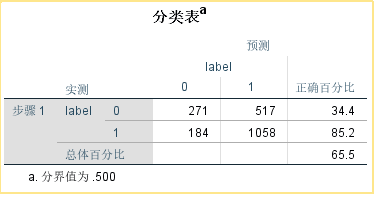
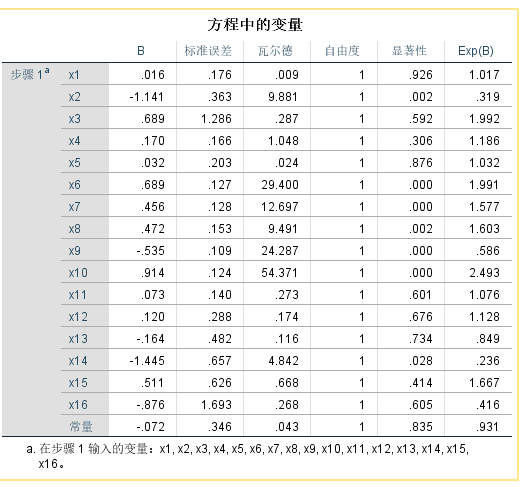

可以看到，二元逻辑回归的准确率在65.5，这对于预测一个选手在实际比赛中能否获得得分已经有了一个还不错的预测效果，至少可以说明这个模型是能够辅助用于评价选手的表现能力的。
* 另一方面，对于方程中的变量分析，发现其中一半的变量对于模型的预测是显著的，其中主要包括x2,x6,x7,x8,x9,x10,x14
#### 额外的，因为二元逻辑回归的性能本身是有限的，我们希望能够选取更加优秀的模型进行预测，所以采用了一些经典的机器学习算法进行对比，使用accuracy、recall、precision、f1和auc进行评价，使用5折交叉验证法进行验证，结果如下:

In [6]:
import warnings
warnings.filterwarnings("ignore")

def function(model):
    auc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='roc_auc').mean(),2)
    acc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='f1').mean(),2)
    return acc,recall,precision,f1,auc

model = LGBMClassifier(random_state=30,force_col_wise=True)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{function(model)}')
model = XGBClassifier(random_state=50)
print(f'XGBClassifier acc,recall,precision,f1,auc :{function(model)}')
model = SVC(random_state=50)
print(f'SVC acc,recall,precision,f1,auc :{function(model)}')
model = MLPClassifier(random_state=60)
print(f'MLPClassifier acc,recall,precision,f1,auc :{function(model)}')
model = LogisticRegression(random_state=50)
print(f'LogisticRegression acc,recall,precision,f1,auc :{function(model)}')

[LightGBM] [Info] Number of positive: 2559, number of negative: 2420
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513959 -> initscore=0.055849
[LightGBM] [Info] Start training from score 0.055849
[LightGBM] [Info] Number of positive: 2558, number of negative: 2421
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513758 -> initscore=0.055045
[LightGBM] [Info] Start training from score 0.055045
[LightGBM] [Info] Number of positive: 2558, number of negative: 2421
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513758 -> initscore=0.055045
[LightGBM] [Info] Start training from score 0.055045
[LightGBM] [Info] Numb

XGBClassifier acc,recall,precision,f1,auc :(0.67, 0.68, 0.68, 0.68, 0.75)
SVC acc,recall,precision,f1,auc :(0.67, 0.65, 0.7, 0.67, 0.75)
MLPClassifier acc,recall,precision,f1,auc :(0.69, 0.66, 0.71, 0.68, 0.76)
LogisticRegression acc,recall,precision,f1,auc :(0.67, 0.69, 0.67, 0.68, 0.72)


[LightGBM] [Info] Number of positive: 2573, number of negative: 2406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516770 -> initscore=0.067107
[LightGBM] [Info] Start training from score 0.067107


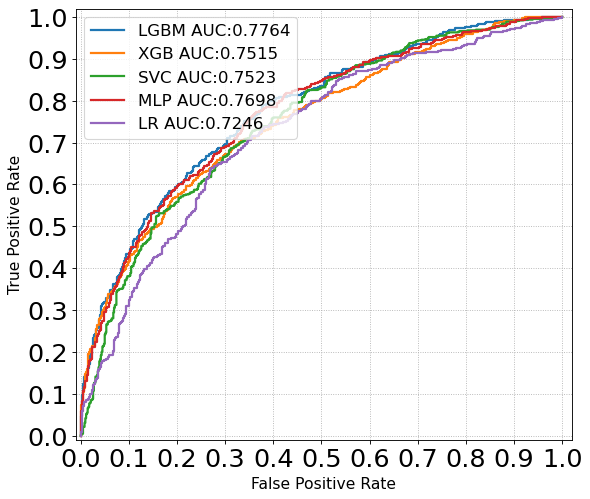

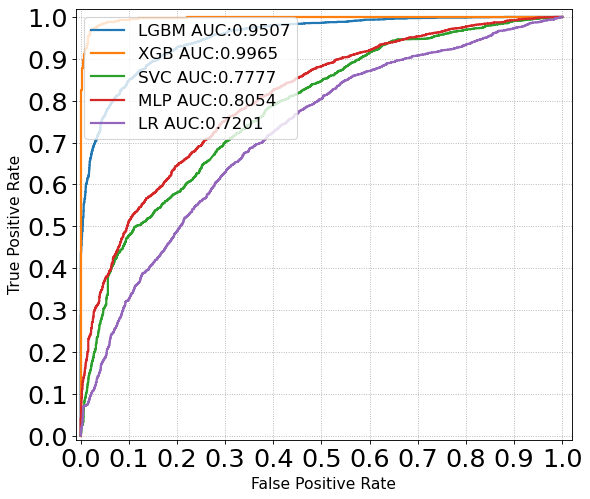

In [10]:
import numpy as np
from sklearn import metrics
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    if types == 'test':
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xvalid)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    else:
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    plt.legend(loc='upper left',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    plt.savefig(f'问题1\\roc_auc({types}(采样前)).png',dpi=500)
    plt.show()
    

xtrain, xvalid, ytrain, yvalid = train_test_split(dataset[columns].values,dataset['label'].values,random_state=620,test_size=0.2)

model1 = LGBMClassifier(random_state=30)
model2 = XGBClassifier(random_state=50)
model3 = SVC(probability=True,random_state=50)
model4 = MLPClassifier(random_state=60)
model5 = LogisticRegression(random_state=50)

model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)


f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'test')
f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'train')

LGBM的效果最好，相对于二元逻辑回归拥有明显提升,输出其特征重要性得分

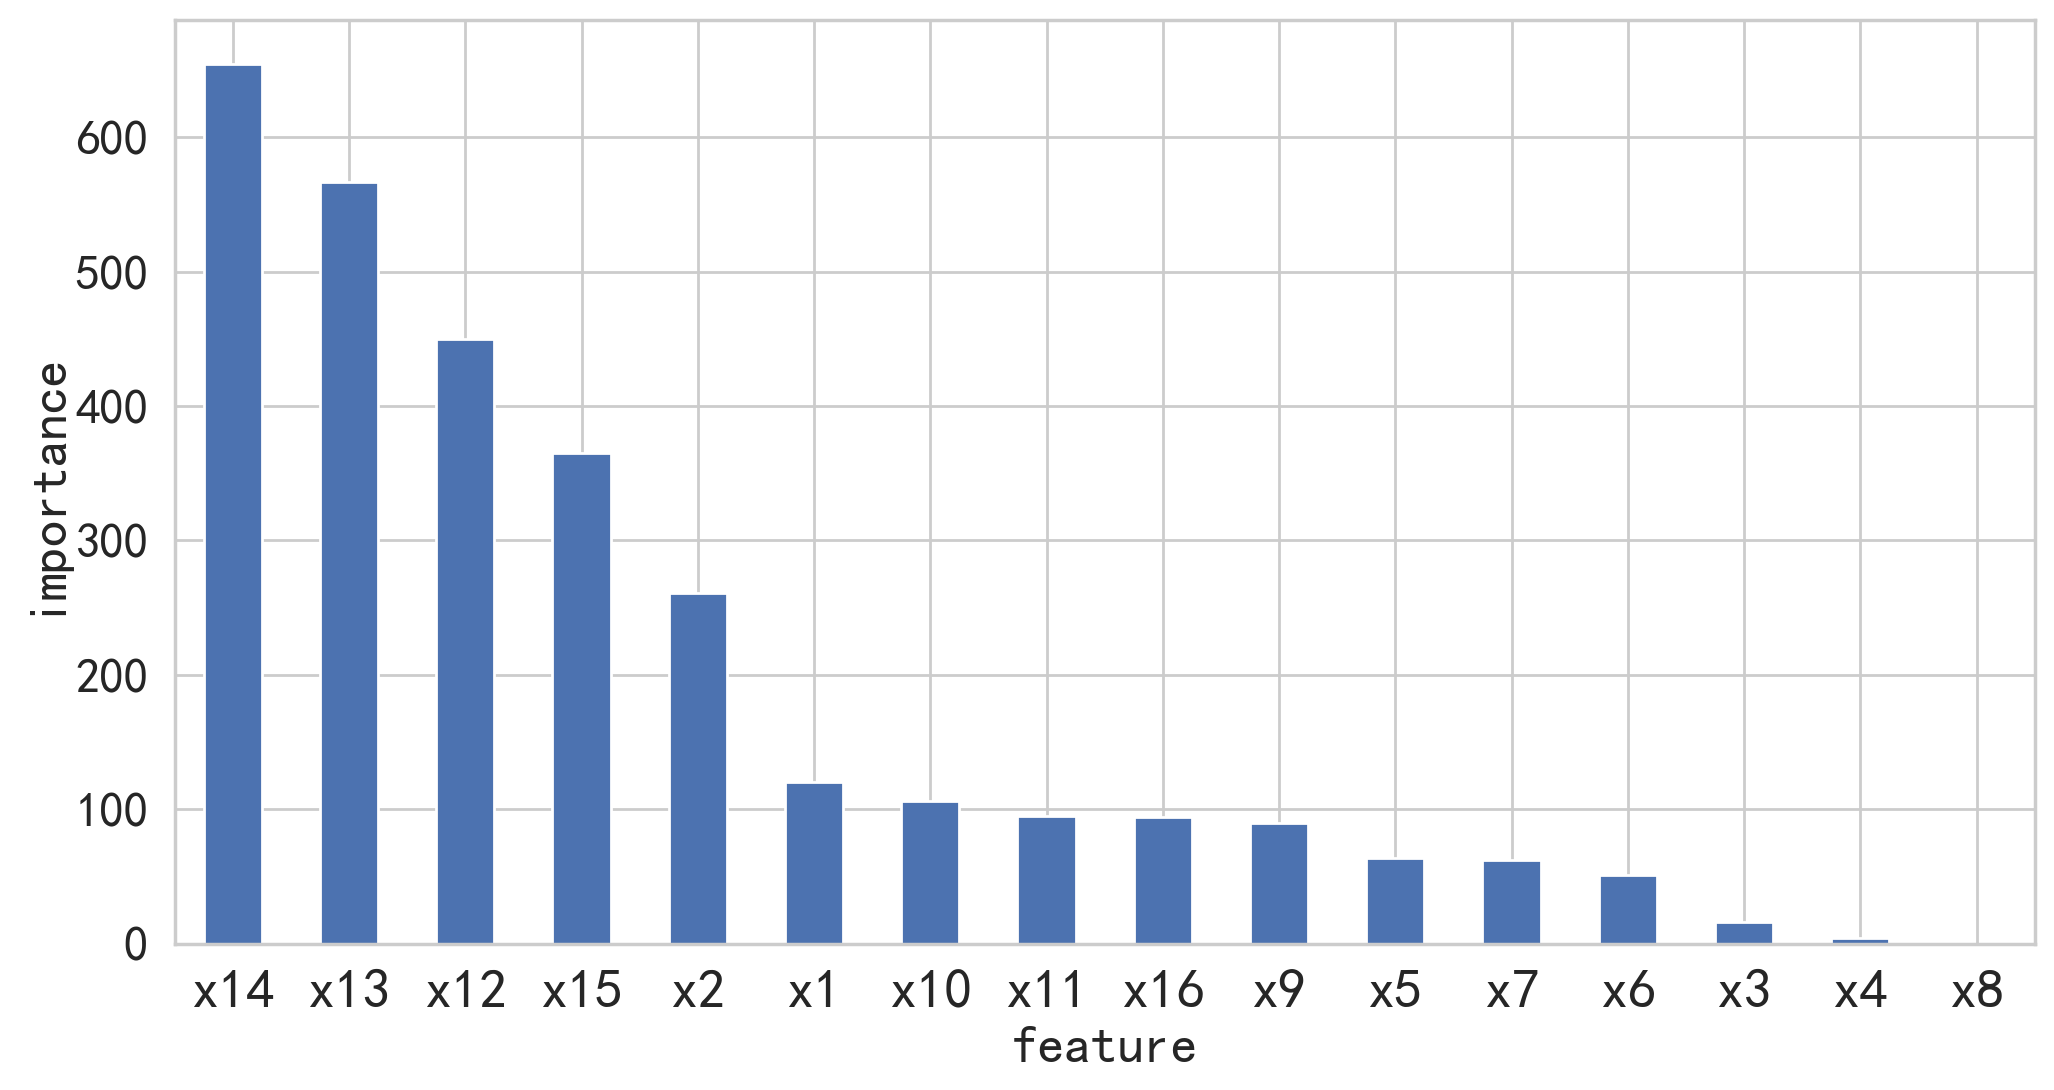

In [14]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
import matplotlib.pyplot as plt
import plotly.express as px

#输出重要性得分
f = pd.DataFrame({'col':list(columns),'score':model1.feature_importances_}).sort_values(by='score',ascending=False)
f.index = f['col']
f["score"].plot(kind = "bar",figsize = (12,6)) #颜色,matplotlib
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(rotation = 0,fontsize = 20)
plt.savefig('问题1\\特征重要性得分.png',dpi=500,bbox_inches='tight')
plt.show()

#### 在这一基础上，我们重新训练模型，使用表现最好的LGBM模型，选取 2023 年温布尔登男单决赛中，20 岁的西班牙新星卡洛斯·阿尔卡拉兹击败了 36 岁的诺瓦 克·德约科维奇的经典对局进行实时的表现可视化，选取的选手为Carlos Alcaraz

In [15]:
index = df[df.match_id=='2023-wimbledon-1701'].reset_index(drop=True).index
test = dataset.iloc[index]
train = dataset.drop(index,axis=0)

In [20]:
model = LGBMClassifier(random_state=30)
model.fit(train[columns].values,train['label'].values)
pred = model.predict_proba(test[columns].values)
pred = pd.DataFrame({'实时得分':pred[:,1]})

[LightGBM] [Info] Number of positive: 3031, number of negative: 2882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 5913, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512599 -> initscore=0.050408
[LightGBM] [Info] Start training from score 0.050408


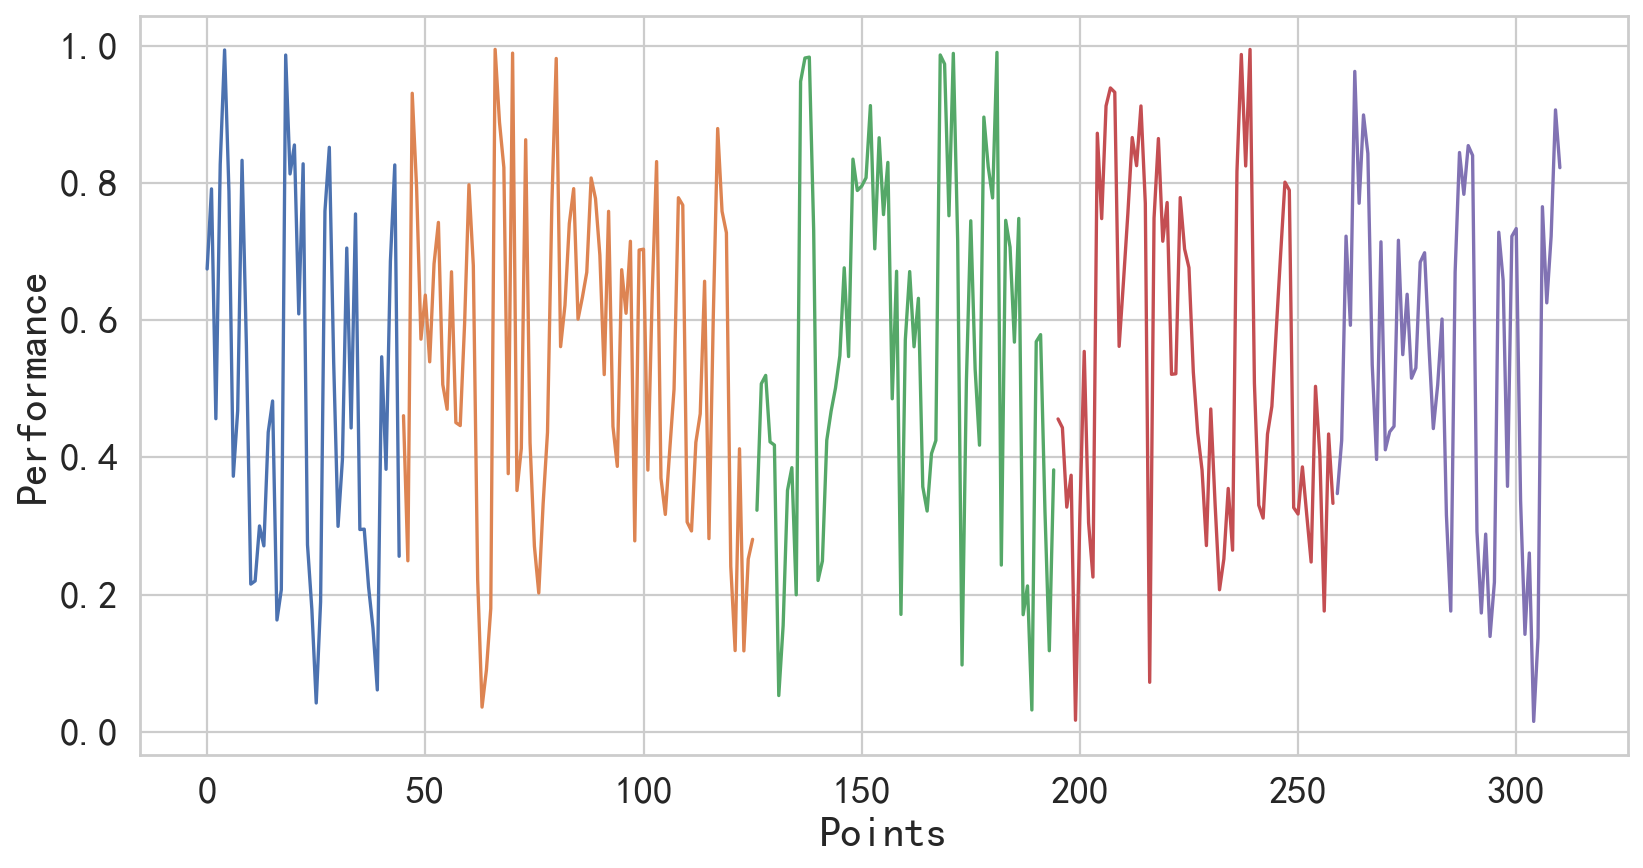

In [21]:
match1 = pred.iloc[:45]
match2 = pred.iloc[45:126]
match3 = pred.iloc[126:195]
match4 = pred.iloc[195:259]
match5 = pred.iloc[259:]

plt.figure(figsize=(12, 6), dpi=80, facecolor='w')
plt.plot(match1.index,match1.values)
plt.plot(match2.index,match2.values)
plt.plot(match3.index,match3.values)
plt.plot(match4.index,match4.values)
plt.plot(match5.index,match5.values)

plt.xlabel("Points")
plt.ylabel("Performance")
plt.savefig('问题1\\经典对决实时走势.png',dpi=500)
plt.show()

#### 实际上，对于得分点的预测准确性能是有上限的，这也和我们的直觉相似，因为具体选手是否能得分的影响因素太过于复杂，使得在没有考虑这些复杂因素时，选手得分的噪音会非常严重，因此，对于模型而言，只能准确地判别其中0.7部分的选手真实得分情况，刚好对于这个经典战役预测是没有意义的。根据分析，我们发现这个经典之战的发球者和得分者刚好成反关系，以及存在一些其他的与正常情况不符合的现象，所以难以进行预测，但实际上，本文提出的这种模型仍然是有效的。

### 问题2： 一位网球教练对“动量”在比赛中起作用持怀疑态度。相反，他认为一个球员在比赛中 的摇摆和成功是随机的。用你的模型/指标来评估这一说法。

### 针对问题2，我们只需要使用已经训练好的模型对所有样本进行预测，这个预测值其实就被称为“动量”，在这基础之上，只需要证明这个动量与实际选手得分的情况的相关性是显著的，并且能够显著影响比赛结果，即可说明动量在比赛中是起作用的。

我们使用皮尔逊相关系数检验分析相关系，一元线性回归分析影响性

In [27]:
import scipy.stats as stats
 
# 定义两组变量
model = LGBMClassifier(random_state=30)
model.fit(xtrain,ytrain)
 
pred = model.predict_proba(xvalid)[:,1]
# 计算Pearson相关系数
corr_coef, p_value = stats.pearsonr(pred, yvalid)
print("Pearson相关系数为:", round(corr_coef,3))
print("p值为:", p_value)

[LightGBM] [Info] Number of positive: 2573, number of negative: 2406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 4979, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516770 -> initscore=0.067107
[LightGBM] [Info] Start training from score 0.067107
Pearson相关系数为: 0.482
p值为: 1.7389646326034744e-73


In [28]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm


y = yvalid
x = pred
X = sm.add_constant(x)
model = OLS(y,X,fit_intercept=True).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     376.6
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           1.74e-73
Time:                        13:24:06   Log-Likelihood:                -738.86
No. Observations:                1245   AIC:                             1482.
Df Residuals:                    1243   BIC:                             1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0320      0.027      1.176      0.2

D:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['fit_intercept']
  warnings.warn(msg, ValueWarning)


#### 可以看到，动量x1对结果的影响是显著的，可以解释结果中的0.233部分